# Домашнее задание "Методология ведения DS-проектов"
Возьмите задачу с винами (https://www.kaggle.com/rajyellow46/wine-quality) и решите ее, оформив в виде CrispDM-подхода. Решение - jupyter notebook на github или colab.

# 1. Понимание бизнеса

## 1.1 Цель

- Установить качество вина в завимости от его физико-химических свойств

![title](dataset-card.jpg)

## 1.2 Описание

<div class="alert alert-info">
<b>Data Set Information: </b>
    
Датасет содержит данные о красных и белых вариантах португальского вина "Винью Верде".  Из-за проблем с конфиденциальностью и логистикой доступны только физико-химические (исходные) и сенсорные (выходные) переменные (например, нет данных о сортах винограда, марке вина, продажной цене вина и т. Д.).
</div>

Эти наборы данных можно рассматривать как задачи классификации или регрессии. Классы упорядочены и не сбалансированы (например, нормальных вин употребляют больше, чем отличных или плохих). Алгоритмы обнаружения выбросов могут использоваться для обнаружения нескольких отличных или плохих вин. Кроме того, мы не уверены, все ли входные переменные актуальны. Так что было бы интересно провести feature selection.

Два набора данных были объединены, и несколько значений были удалены случайным образом.

Взято с Kaggle (https://www.kaggle.com/rajyellow46/wine-quality)

# 2. Data undestanding

## 2.1 Import Libraries

In [1]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Handle table-like data and matrices
import pandas as pd

# Modelling algorithms
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

# Modelling helpers
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

# Visualisation
import seaborn as sns
from matplotlib import pyplot as plt

# configure visualisation
from pylab import rcParams
rcParams['figure.figsize'] = 13,6
%matplotlib inline

## 2.2 Вспомогательные функции 

In [2]:
def fill_missings(data, cols, value='mean'):
    if value == 'mean':
        for col in cols:
            data[col].fillna(data[col].mean(), inplace=True)
    
    elif value == 'median':
        for col in cols:
            data[col].fillna(data[col].median(), inplace=True)
    
    elif value == 'type_transorm':
        for col in cols:
            data[col].fillna(data.groupby(['type'])[col].transform('mean'), inplace=True)
    
    elif isinstance(value, float) or isinstance(value, int):
        for col in cols:
            data[col].fillna(value, inplace=True)
            
    return data

def plot_scatter_and_lin(x_col, y_col):
    model = LinearRegression()
    X = data[[x_col]]
    y = data[y_col]
    model.fit(X, y)
    y_pred = model.predict(X)
    _, ax = plt.subplots(figsize=(8,6))
    plt.scatter(X, y, s=5, color='steelblue')
    plt.xlabel(x_col)
    plt.ylabel(y_col)
    plt.title(f'{x_col} vs. {y_col}')
    plt.grid()
    plt.plot(X, y_pred, c='black')

def plot_variable_importance(X, y):
    tree = DecisionTreeClassifier(random_state=0)
    tree.fit(X, y)
    plot_model_var_imp(tree, X, y)


def plot_model_var_imp(model, X, y):
    imp = pd.DataFrame(
        model.feature_importances_,
        columns=['Importance'],
        index=X.columns
    )
    imp = imp.sort_values(['Importance'], ascending=True)
    imp[:10].plot(kind='barh')
    
def plot_distribution(df, var, target, **kwargs):
    row = kwargs.get('row', None)
    col = kwargs.get('col', None)
    facet = sns.FacetGrid(df, hue=target, aspect=4, row=row, col=col)
    facet.map(sns.kdeplot, var, shade=True)
    facet.set( xlim= (0, df[var].max()))
    facet.add_legend()
    
def plot_corr_heatmap(corr):
    _, ax = plt.subplots(figsize=(12,10))
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    _ = sns.heatmap(corr, cmap=cmap, vmin=-1, vmax=1, annot=True, linewidths=0.5, center=0, )
    
def plot_hist(data, var):
    _, ax = plt.subplots(figsize=(6,4))
    _ = sns.countplot(var, data=data, ax=ax, palette="Set2")
    ax.set_title(f"Распределение значений переменной {var}")
    plt.show()

## 2.3 Загрузка данных

In [3]:
data = pd.read_csv('winequalityN.csv')

## 2.4 Статистика и визуализации

In [4]:
data.head()

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,white,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,white,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,white,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


### Описание переменных

<div class="alert alert-success">
<b> quality</b>
    
качество вина на основе сенсорных данных (от 0 до 10 баллов)
</div>

<div class="alert alert-info">
<b> fixed acidity</b>

нелетучая кислотность (винная кислота - г / ${дм}^3$): большинство винных кислот либо фиксированные (фиксированные кислоты) либо нелетучие (не испаряются быстро)
</div>

<div class="alert alert-info ">
<b> volatile acidity</b>

летучая кислотность (уксусная кислота - г / ${дм}^3$): количество уксусной кислоты в вине, слишком высокое содержание которой может привести к неприятному вкусу уксуса.
</div>

<div class="alert alert-info ">
<b> citric acid</b>

лимонная кислота (г / ${дм}^3$): в небольших количествах лимонная кислота может придавать винам «свежесть» и аромат.
</div>

<div class="alert alert-danger">
<b> residual sugar</b>
    
остаточный сахар (г / ${дм}^3$): количество сахара, оставшееся после остановки брожения, редко можно найти вина с концентрацией менее 1 грамма / литр, а вина с концентрацией более 45 граммов / литр считаются сладкими.
</div>

<div class="alert alert-danger">
<b> chlorides</b>

chlorides: хлориды (поваренная соль - г / ${дм}^3$): количество соли в вине
</div>

<div class="alert alert-danger ">
<b> free sulfur dioxide</b>

свободный диоксид серы (мг / ${дм}^3$): свободная форма $S{O}_2$ находится в равновесии между молекулярным $S{O}_2$ (в виде растворенного газа) и бисульфит-ионом; предотвращает рост микробов и окисление вина
</div>

<div class="alert alert-warning ">
<b> total sulfur dioxide</b>

диоксид серы общий (мг / ${дм}^3$): количество свободной и связанной форм $S{O}_2$; в низких концентрациях $S{O}_2$ в основном не обнаруживается в вине, но при концентрациях свободного $S{O}_2$ более 50 частей на миллион $S{O}_2$ становится очевидным в носу и вкусе вина.
</div>

<div class="alert alert-warning ">
<b> density</b>

плотность (г / ${см}^3$): плотность вина близка к плотности воды в зависимости от процентного содержания спирта и сахара.
</div>

<div class="alert alert-warning ">
<b> pH</b>

мера кислотности водных растворов pH описывает, насколько вино кислое или основное, по шкале от 0 (очень кислая) до 14 (очень щелочная); у большинства вин уровень pH составляет 3-4
</div>

<div class="alert alert-success">
<b> sulphates</b>
    
сульфаты (сульфат калия - г / ${дм}^3$): винная добавка, которая может способствовать повышению уровня газообразного диоксида серы ($S{O}_2$), который действует как антимикробное и антиоксидантное средство.
</div>

<div class="alert alert-success">
<b> alcohol</b>
    
алкоголь (% от объема):  процентное содержание алкоголя в вине.
</div>

<div class="alert alert-success">
<b> type</b>
    
тип вина: красное или белое
</div>

- quality: качество (от 0 до 10 баллов): на основе сенсорных данных


- fixed acidity: нелетучая кислотность (винная кислота - г / ${дм}^3$): большинство кислот, связанных с вином, фиксированные или нелетучие (не испаряются быстро)


- volatile acidity: летучая кислотность (уксусная кислота - г / ${дм}^3$): количество уксусной кислоты в вине, слишком высокое содержание которой может привести к неприятному вкусу уксуса.


- citric acid: лимонная кислота (г / ${дм}^3$): в небольших количествах лимонная кислота может придавать винам «свежесть» и аромат.


- residual sugar: остаточный сахар (г / ${дм}^3$): количество сахара, оставшееся после остановки брожения, редко можно найти вина с концентрацией менее 1 грамма / литр, а вина с концентрацией более 45 граммов / литр считаются сладкими.


- chlorides: хлориды (поваренная соль - г / ${дм}^3$): количество соли в вине


- free sulfur dioxide: свободный диоксид серы (мг / ${дм}^3$): свободная форма $S{O}_2$ находится в равновесии между молекулярным $S{O}_2$ (в виде растворенного газа) и бисульфит-ионом; предотвращает рост микробов и окисление вина


- total sulfur dioxide: диоксид серы общий (мг / ${дм}^3$): количество свободной и связанной форм $S{O}_2$; в низких концентрациях $S{O}_2$ в основном не обнаруживается в вине, но при концентрациях свободного $S{O}_2$ более 50 частей на миллион $S{O}_2$ становится очевидным в носу и вкусе вина.


- density: плотность (г / ${см}^3$): плотность вина близка к плотности воды в зависимости от процентного содержания спирта и сахара.


- pH: мера кислотности водных растворов pH описывает, насколько вино кислое или основное, по шкале от 0 (очень кислая) до 14 (очень щелочная); у большинства вин уровень pH составляет 3-4


- sulphates: сульфаты (сульфат калия - г / ${дм}^3$): винная добавка, которая может способствовать повышению уровня газообразного диоксида серы ($S{O}_2$), который действует как антимикробное и антиоксидантное средство.


- alcohol: алкоголь (% от объема):  процентное содержание алкоголя в вине.


### 2.4.1 Ключевая информация о переменных

По описанию данных видно, что пропущенных значений немного. Минимальный балл оценки качества вина 3, максимальный 9. Также из данных заметно, что плотность практически не изменяется и примерно равна плотности воды. Среднее значение остаточного сахара 5,4 г / ${дм}^3$, максимальное значение остаточного сахара 65,8 ( больше 45 г / ${дм}^3$ считается сладкими винами). Среднее значение свободного диоксида серы 30 мг / ${дм}^3$, максимальное значение 289, что выходит за 75% процентиль. рН вина от 2,7 до 4, среднее 3,2. Нет вин с щелочными свойствами (максимальный рН = 4). Минимальный балл качества 3, средний 5,8, высший 9.

In [5]:
data.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,6487.000000,6489.000000,6494.000000,6495.000000,6495.000000,6497.000000,6497.000000,6497.000000,6488.000000,6493.000000,6497.000000,6497.000000
mean,7.216579,0.339691,0.318722,5.444326,0.056042,30.525319,115.744574,0.994697,3.218395,0.531215,10.491801,5.818378
std,1.296750,0.164649,0.145265,4.758125,0.035036,17.749400,56.521855,0.002999,0.160748,0.148814,1.192712,0.873255
min,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,77.000000,0.992340,3.110000,0.430000,9.500000,5.000000
50%,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994890,3.210000,0.510000,10.300000,6.000000
75%,7.700000,0.400000,0.390000,8.100000,0.065000,41.000000,156.000000,0.996990,3.320000,0.600000,11.300000,6.000000
max,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000,9.000000


### 2.4.2 Тепловая карта (дает понимание того, какие признаки важны)

Самый высокий коэффициент корреляции - между качеством вина и процентным содержанием в нем алкоголя (0,44)

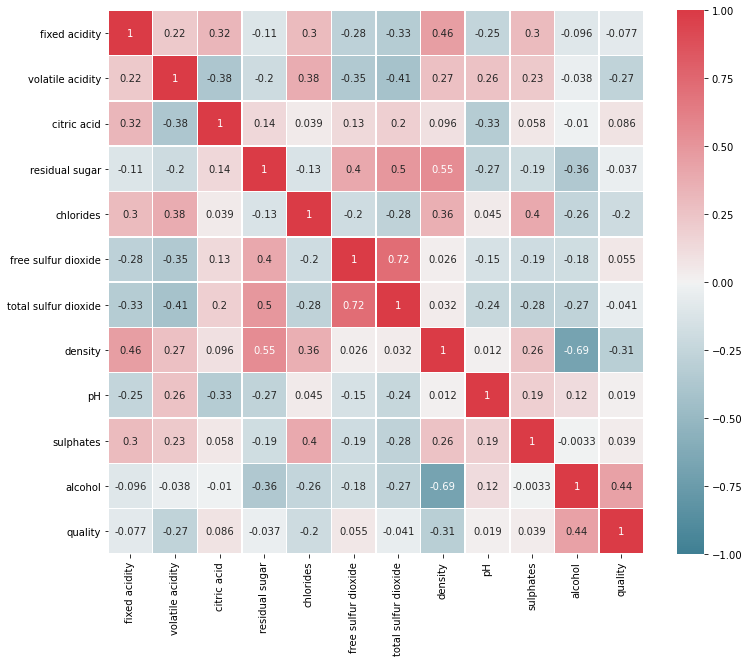

In [6]:
corr = data.corr()
plot_corr_heatmap(corr)

### 2.4.3 Распределение баллов качества

Больше всего оценок вина в 6 баллов, оценок 3 и 9 очень мало. То есть в среднем качество вина в данном датасете нормальное.

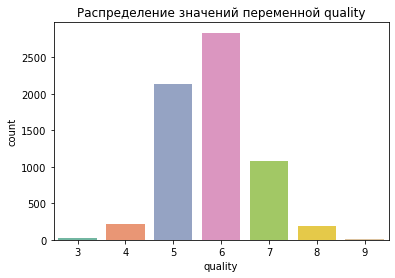

In [7]:
plot_hist(data, var='quality')

### 2.4.4 Распределение типов вина

Белого вина в датасета намного больше, чем красного.

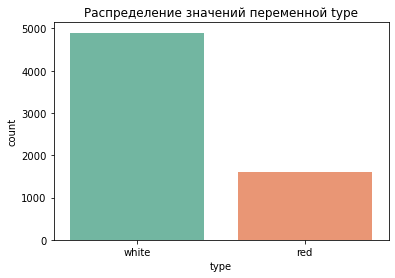

In [8]:
plot_hist(data, var='type')

### 2.4.5 Распределение качества вина по его типам

По графику видно, что белое вино оценивают лучше, тогда как оценки ниже среднего принадлежат красным винам.

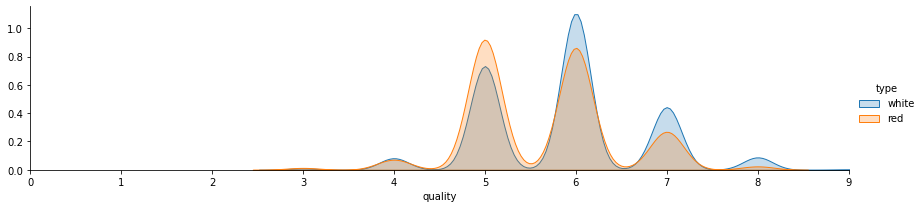

In [9]:
plot_distribution(data, var='quality', target='type')

### 2.4.6 Распределение процентного содержания алкоголя по типам вина

Распределение процентного содержания алкоголя по обоим типам вина перекошено. 
Чаще всего в винах содержится 9,5%, в среднем 10,49% алкоголя.

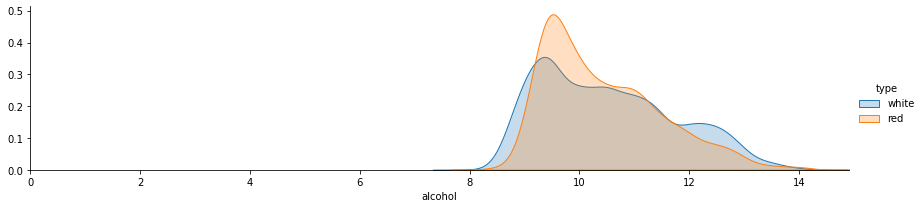

In [10]:
plot_distribution(data, var='alcohol', target='type')

### 2.4.7 Ящик с усами для поиска выбросов

Максимальное значение остаточного сахара 65,8 считаем выбросом.

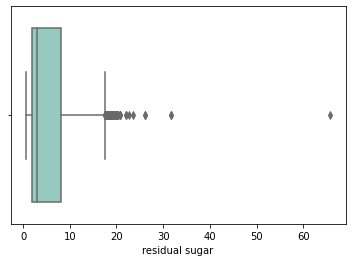

In [11]:
ax = sns.boxplot(data=data, x='residual sugar',  palette="Set3")

Значение концентрации свободного диоксида серы 289 мг / ${дм}^3$ тоже считаем выбросом.

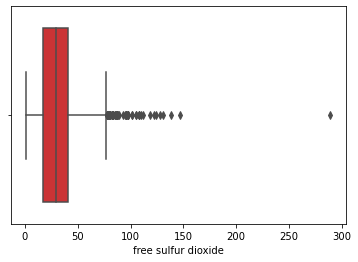

In [12]:
ax = sns.boxplot(data=data, x='free sulfur dioxide', palette="Set1")

### 2.4.8 Графики высококоррелированных переменных

Корреляция между полным и свободным оксидом серы равна 0,72. На графике наблюдается линейная зависимость переменных

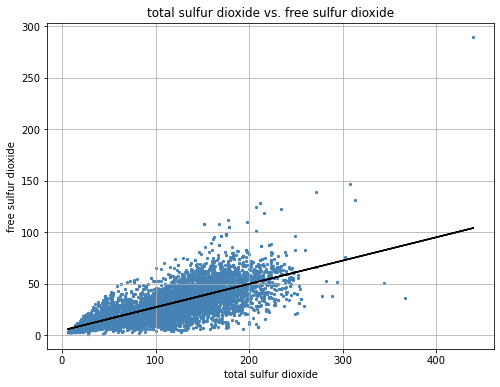

In [13]:
plot_scatter_and_lin(x_col='total sulfur dioxide', y_col='free sulfur dioxide')

Корреляция между процентным содержанием алкоголя и плотность вина равна -0,49. Чем меньше алкоголя в вине, чем меньше плотность этого вина, и соотвественно, ближе к плотности воды.

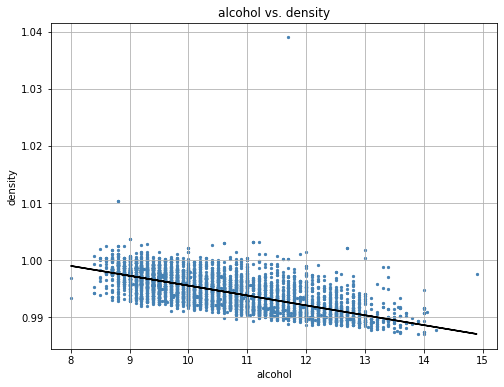

In [14]:
plot_scatter_and_lin(x_col='alcohol', y_col='density')

# 3. Data Preparation

## 3.1  Обработка пропущенных значений

In [15]:
print('Количество пропусков:')
missing_cols = []
for col in data.columns:
    pct_missing = data[col].isnull().sum()
    if pct_missing > 0:
        print(f'{col} - {pct_missing}')
        missing_cols.append(col)
# print(f'target (quality) - {target.isnull().sum()}')

Количество пропусков:
fixed acidity - 10
volatile acidity - 8
citric acid - 3
residual sugar - 2
chlorides - 2
pH - 9
sulphates - 4


In [16]:
data = fill_missings(data, cols=missing_cols, value='type_transorm')
data.head()

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,white,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,white,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,white,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


## 3.2  Обработка выбросов

Удаляем выбросы:
* остаточный сахар 65,8
* концентрация свободного диоксида серы 289.

In [17]:
data = data[(data['free sulfur dioxide'] < 289) & (data['residual sugar'] < 65)].copy()

## 3.3  Обработка категориальных признаков

Категориальный признак только один: type - вид вина (красное или белое), его переведем в числовой формат с помощью OneHotEndcoding.

In [18]:
cat_features = ['type']
cont_features = [x for x in data.columns if x not in cat_features and x != 'quality']

In [19]:
data_type = pd.get_dummies(data=data['type'])

## 3.4  Feature Engineering - добавляем новые признаки

Добавим новый признак - концентрация свободного диоксида серы, так как при высоких концентрациях диоксида серы становится ощутимым во вкусе вина.

In [20]:
data['free sulfur dioxide concentration'] = data['free sulfur dioxide'] / data['total sulfur dioxide']

## 3.5  Сборка финальных датасетов для моделирования

### 3.5.1  Выбор переменных

Выбираем признаки для формирования итогового датасета. У нас доступны признаки:
- type
- fixed acidity
- volatile acidity
- citric acid
- residual sugar
- chlorides
- free sulfur dioxide
- total sulfur dioxide
- density
- pH
- sulphates
- alcohol

- bound sulfur dioxide
    

In [21]:
X = pd.concat([data.drop(columns=cat_features), data_type], axis=1)
X.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,free sulfur dioxide concentration,red,white
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6,0.264706,0,1
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6,0.106061,0,1
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6,0.309278,0,1
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6,0.252688,0,1
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6,0.252688,0,1


### 3.5.2  Создание датасетов

Отделяем данные для обучения и проверки

In [22]:
X = X.drop('quality',axis=1)
y = data['quality']

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

### 3.5.3 Важность признаков

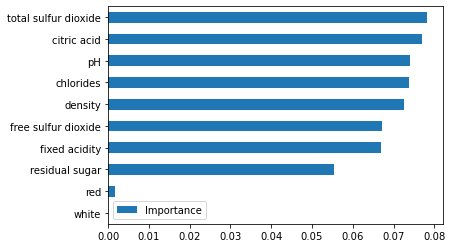

In [24]:
plot_variable_importance(X_train, y_train,)

# 4. Моделирование

Используем обучающий набор данных для обучения модели и затем проверим ее с помощью тестового набора.

## 4.1 Выбор модели

Попробуем модель на основе метода k-ближайших соседей - KNeighborsClassifier

In [25]:
neigh = KNeighborsClassifier()

## 4.1.1 Обучение модели KNN

In [26]:
neigh.fit(X_train, y_train)

KNeighborsClassifier()

## 4.1.2 Оценка модели KNN

In [27]:
# Score the model
print(neigh.score(X_test, y_test))

0.4819091608929946


## 4.2 Выбор альтернативной модели

Попробуем модель на основе случайного леса  - RandomForestClassifier

In [28]:
clf_rf = RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_leaf=2, n_jobs=-1)

## 4.2.1 Обучение модели RandomForest

In [29]:
clf_rf.fit(X_train, y_train)   

RandomForestClassifier(max_depth=10, min_samples_leaf=2, n_jobs=-1)

## 4.2.2 Оценка модели RandomForest

In [30]:
# Score the model
print(clf_rf.score(X_test, y_test))

0.6374133949191686


## 4.2.3 Подбор оптимальных гиперпараметров модели RandomForest

In [31]:
params = [ {'n_estimators':[50, 100], 'max_depth': list(range(5, 21))} ]

In [32]:
gs = GridSearchCV(RandomForestClassifier(), 
                  param_grid = params, 
                  scoring = 'accuracy',
                  cv=10,
                  return_train_score = False )

In [33]:
gs.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=RandomForestClassifier(),
             param_grid=[{'max_depth': [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15,
                                        16, 17, 18, 19, 20],
                          'n_estimators': [50, 100]}],
             scoring='accuracy')

In [35]:
best_params = gs.best_params_
best_params

{'max_depth': 19, 'n_estimators': 100}

In [36]:
rfc = RandomForestClassifier(n_estimators=best_params['n_estimators'], max_depth=best_params['max_depth'], n_jobs=-1)
rfc.fit(X_train, y_train)   

RandomForestClassifier(max_depth=19, n_jobs=-1)

In [37]:
rfc.score(X_test, y_test)

0.6859122401847575

# 5. Выбор лучшей модели по оценке

В заключение по оценкам точности по разным моделям:

1. модель KNN с точностью 0,48
2. модель RandomForestClassifier без подбора гиперпараметров с точностью 0,63
3. модель RandomForestClassifier м подбором гиперпараметров с точностью 0,68

Лучшей по оценке можно считать модель случайного леса с подобранными параметрами и точностью оценки 0,68.